In [3]:
library(tidyverse)
options(repr.plot.width=5, repr.plot.height=4)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# STATS 306
## Homework 5: Relational Data and SQL

For each problem, enter the R code in the cell marked "YOUR SOLUTION HERE". All of the problems in this problem set use the `nycflights13` data:

This package provides the following data tables.

* `?flights`: all flights that departed from NYC in 2013
* `?weather`: hourly meterological data for each airport
* `?planes`: construction information about each plane
* `?airports`: airport names and locations
* `?airlines`: translation between two letter carrier codes and names

In [4]:
install.packages('nycflights13') # if necessary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(nycflights13)

## Problem 1: Joins (4 points)


**(a)** Is there a relationship between a) a plane's age, and b) the proportion of flights schedule to use that plane that got cancelled? Here we consider a flight cancellation to be when `dep_time` is `NA` as described in HW 3 Problem 1 (b): 1 point

In [4]:
# Your solution here

flightsCancelled <- flights %>%
    inner_join(planes, by = "tailnum") %>%
    mutate(age = 2023-year.y) %>%
    select(age, dep_time) %>%
    mutate(isCancelled = is.na(dep_time))%>%
    group_by(age) %>%
    mutate(propFlightsCancelled = mean(isCancelled)) 

Warning message:
“Removed 5306 rows containing missing values (`geom_point()`).”


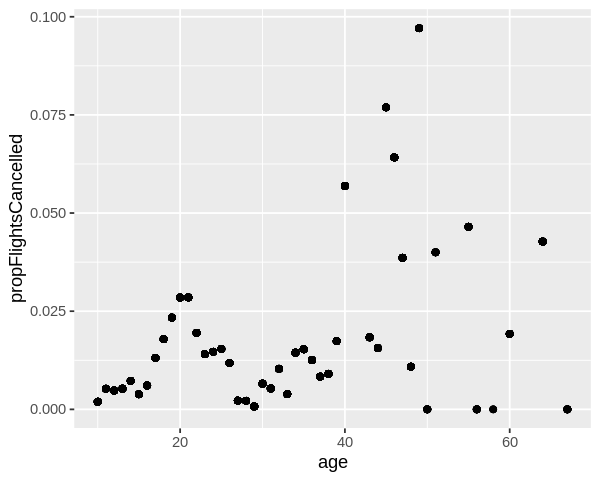

In [5]:
flightsCancelled %>%
    ggplot(aes(x=age, y=propFlightsCancelled))  +
    geom_point()

In [6]:
cor(flightsCancelled$age, flightsCancelled$propFlightsCancelled, method = "pearson", use = "pairwise.complete.obs")

[1] 0.1456246

There does not appear to be a relationship between a plane's age and the proportion of flights scheduled to use that plane of that age. As we see from the scatterplot, the points are randomly distributed and follow no clear pattern. Also, the correlaiton coefficient is 0.145 which is close to 0, indicating a very week relationship. 

**(b)** Are some planes used by multiple carriers? (Recall that each plane is uniquely identified by its `tailnum`.) _1 point_

In [8]:
# Your solution here

flights %>%
  group_by(tailnum) %>%
  summarise(distinctCarriers = n_distinct(carrier)) %>%
  filter(distinctCarriers>1)

tailnum,distinctCarriers
<chr>,<int>
N146PQ,2
N153PQ,2
N176PQ,2
N181PQ,2
N197PQ,2
N200PQ,2
N228PQ,2
N232PQ,2
N933AT,2


Yes, there are 18 planes (including one NA plane) that uses multiple carriers.

install.packages("maps")In the next few problems you are asked to draw some data on a map of the United States. Fortunately, this is easy to do using `ggplot`. Here is an example which draws the location of each airport in the dataset:

In [7]:
install.packages("maps") # if necessary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



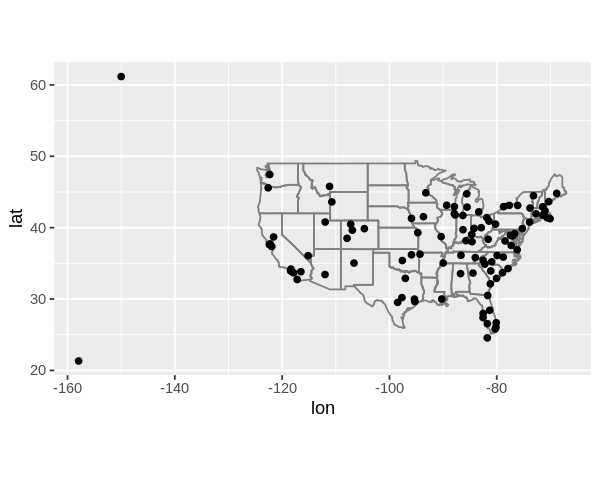

In [9]:
airports  %>% 
  semi_join(flights, by=c("faa"="dest")) %>% 
  ggplot(aes(x = lon, y = lat)) +
    borders("state") +
    geom_point() +
    coord_quickmap()

**(c)** For each destination in the continental U.S., compute the average arrival delay to that destination, and draw them on a map: _1 point_

Warning message in inner_join(., flights, by = c(faa = "dest")):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 88 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this
  warning.”


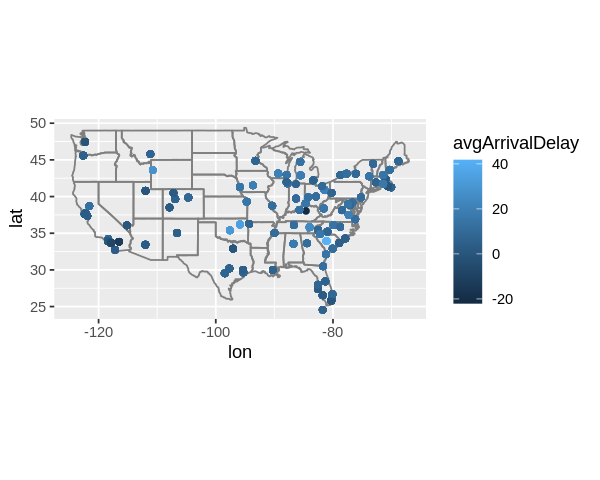

In [10]:
# Your solution here

airports  %>% 
  inner_join(flights, by=c("faa"="dest")) %>%
  drop_na(arr_delay) %>%
  group_by(faa) %>%
  mutate(avgArrivalDelay = mean(arr_delay))  %>%
  ungroup %>%
  filter(!(faa %in% c("ANC","HNL"))) %>%
  ggplot(aes(x = lon, y = lat, color = avgArrivalDelay)) +
    borders("state") +
    geom_point() +
    coord_quickmap()


**(d)** Draw a map of the total number of passengers that flew from NYC to each destination airport in the continental US. (Hint: assume every flight was full, and use the `seats` variable in `planes` to estimate the number of passengers.) _1 point_

Warning message in inner_join(., flights, by = c(faa = "dest")):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 88 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this
  warning.”


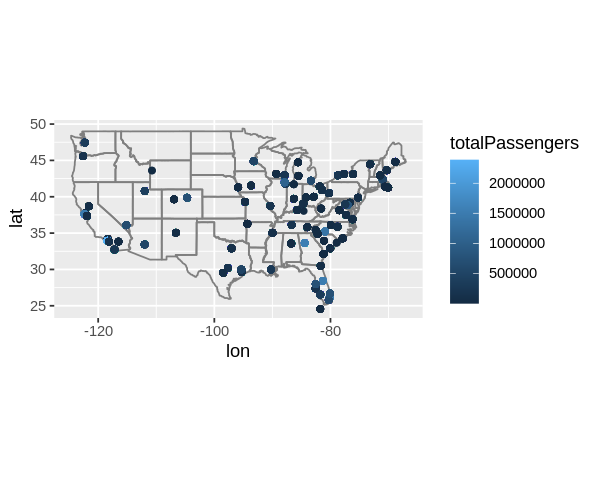

In [13]:
# Your solution here

airports  %>% 
  inner_join(flights, by=c("faa"="dest")) %>%
  inner_join(planes, by = "tailnum") %>%
  filter(!(faa %in% c("ANC","HNL"))) %>%
  filter(origin %in% c("LGA","JFK")) %>%
  group_by(faa) %>%
  mutate(totalPassengers = sum(seats)) %>%
  ggplot(aes(x = lon, y = lat, color = totalPassengers)) +
  borders("state") +
  geom_point() +
  coord_quickmap()



## Problem 2, Weather Delays (4 points)

Use the tables in the `nycflights13` package to answer the following questions:



**(a)** The average departure delay during the first two days of the year was:

In [14]:
flights %>% filter(month == 1, day %in% c(1, 2)) %>% summarise(mean(dep_delay, na.rm = T)) %>% print

# A tibble: 1 × 1
  `mean(dep_delay, na.rm = T)`
                         <dbl>
1                         12.8


whereas for the second two days of the year it was: 

In [15]:
flights %>% filter(month == 1, day %in% c(2, 3)) %>% summarise(mean(dep_delay, na.rm = T)) %>% print

# A tibble: 1 × 1
  `mean(dep_delay, na.rm = T)`
                         <dbl>
1                         12.4


What are the two consecutive days in flights with the highest average departure delay? (Hint: use the `lag()` function.) _2 points_

In [16]:
# Your solution here
flights %>%
  group_by(month, day) %>%
  summarise(twoDayDepDelayMean = mean(dep_delay + lag(dep_delay), na.rm = T)) %>%
  arrange(desc(twoDayDepDelayMean)) 

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month,day,twoDayDepDelayMean
<int>,<int>,<dbl>
3,8,167.15789
7,1,112.13864
9,2,106.09704
7,10,105.53515
12,5,104.61481
5,23,102.08486
9,12,99.51815
6,28,97.32759
6,24,94.13719


3/7 and 3/8 are the two consecutive days with the highest average departure delay of 167.16 minutes.

**(b)** Which of humidity, temperature, or precipitation is more likely to cause flight cancellations? (Here cancelation is defined as it was in Problem 1(a).) Study this by comparing the joint distribution of a) the fraction of flights that were cancelled each day and b) (a summary of) each of the three measurements shown above. 

(Hint: use `pivot_longer` to create a data frame with a variable that contains `humidity`, `temperature`, and `precipitation` as values): _2 points_

In [65]:
# Your solution here

weatherDF <- flights %>%
  inner_join(weather, by = c("month", "day", "hour", "year", "origin")) %>%
  mutate(isCancelled = is.na(dep_time)) %>%
  group_by(month, day) %>%
  summarise(propOfFlightsCancelled = mean(isCancelled), meanHumid = mean(humid), meanTemp = mean(temp), meanPrecip = mean(precip))


`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


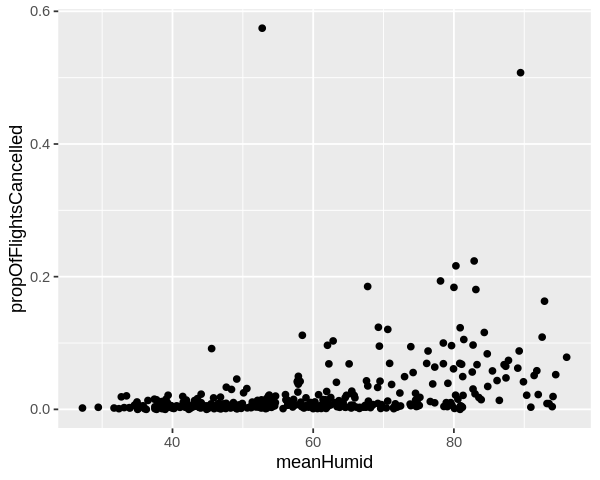

In [66]:
weatherDF %>% ggplot(aes(x = meanHumid, propOfFlightsCancelled)) +
  geom_point()

In [67]:
cor(weatherDF$meanHumid, weatherDF$propOfFlightsCancelled, method = "pearson", use = "pairwise.complete.obs")

[1] 0.3466942

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


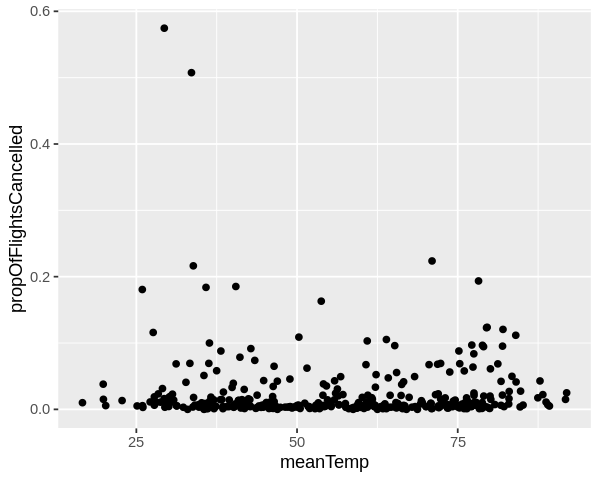

In [68]:
weatherDF %>% ggplot(aes(x = meanTemp, propOfFlightsCancelled)) +
  geom_point()

In [69]:
cor(weatherDF$meanTemp, weatherDF$propOfFlightsCancelled, method = "pearson", use = "pairwise.complete.obs")

[1] -0.05347531

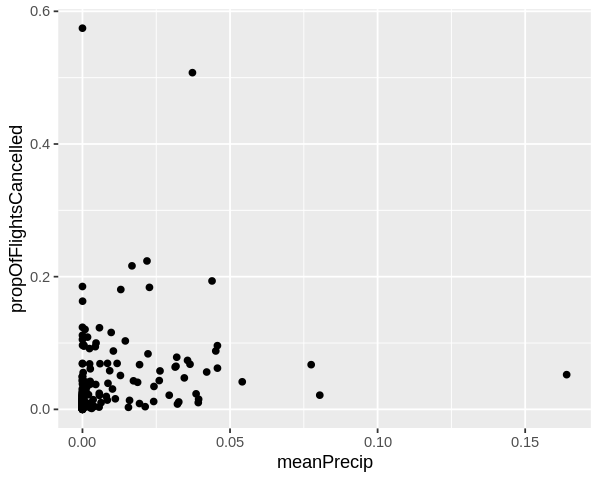

In [70]:
weatherDF %>% ggplot(aes(x = meanPrecip, propOfFlightsCancelled)) +
  geom_point()

In [71]:
cor(weatherDF$meanPrecip, weatherDF$propOfFlightsCancelled, method = "pearson", use = "pairwise.complete.obs")

[1] 0.2738179

Since all the correlation coefficients are very low, there is no strong correlation between weather and proportion of flights cancelled. However, humidity has the highest correlation coefficient of 0.347 making it most likely to cause flight cancellations.

## Challenge problem: Writing SQL queries ( 2 points)
The following code loads `nycflights13` into a SQLite database:

In [6]:
install.packages('RSQLite') # if necessary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘plogr’




In [7]:
# SQLite database
library(nycflights13)
library(DBI)
library(RSQLite)
con <- dbConnect(SQLite(), ":memory:")
copy_to(con, flights, "flights")
copy_to(con, airports, "airports")
copy_to(con, airlines, "airlines")

For each question below, write an appropriate SQL query that produces the answer. For example, if the question was "How many flights departed each month", an appropriate answer would be:

In [26]:
dbGetQuery(con, "SELECT month, COUNT(month) FROM flights GROUP BY month")

month,COUNT(month)
<int>,<int>
1,27004
2,24951
3,28834
4,28330
5,28796
6,28243
7,29425
8,29327
9,27574


**Your answers should only use SQL -- no dplyr allowed!** (However, it is fine to use dplyr to check your answers.)

**(a)** Find the origin and destination with the longest trip for each carrier in the whole dataset, and order your result based on the maximum `air_time`. : 1/2 point

In [38]:
# Your solution here

dbGetQuery(con, 
"SELECT origin, dest, carrier, MAX(air_time) 
FROM flights 
GROUP BY carrier
ORDER By air_time DESC")

origin,dest,carrier,MAX(air_time)
<chr>,<chr>,<chr>,<dbl>
EWR,HNL,UA,695
JFK,HNL,HA,691
JFK,SFO,DL,490
JFK,SFO,AA,426
JFK,SAN,B6,413
JFK,SFO,VX,406
EWR,SEA,AS,392
EWR,PHX,WN,362
JFK,PHX,US,359


**(b)** Find all the busy routes in December 2013 with more than 500 flights in total. (Your query should return the route's origin, destination, and the number of flights.): 1/2 point

In [48]:
# Your solution here

dbGetQuery(con, 
"SELECT origin, dest, COUNT() as NumberOfFlights
FROM flights 
WHERE month = 12
GROUP BY origin, dest
HAVING COUNT() > 500")

origin,dest,COUNT()
<chr>,<chr>,<int>
JFK,LAX,947
JFK,SFO,698
LGA,ATL,862
LGA,CLT,535
LGA,MIA,575
LGA,ORD,637


**(c)** What percentage of the flights were cancelled overall? (A cancelled flight is one for which `dep_delay` is missing.): 1/2 point

In [53]:
# Your solution here

dbGetQuery(con, 
"SELECT AVG(case when dep_delay is null then 1.0 else 0 end) as PercentageOfFlightsCancelled
FROM flights")

PercentageOfFlightsCancelled
<dbl>
0.02451184


**(d)** How many flights are there for each weekday? (Your query should return two columns `num` and `weekday`, where `num` is the number of flights, and `weekday` is the day of week with numerical expressions such as Sunday=0, Monday=1, etc.): 1/2 point

In [8]:
# Your solution here

dbGetQuery(con, 
"SELECT COUNT() as num, strftime('%w',time_hour,'unixepoch') AS weekday
FROM flights 
GROUP BY strftime('%w',time_hour,'unixepoch')")

num,weekday
<int>,<chr>
43796,0
50709,1
50705,2
49998,3
50137,4
50153,5
41278,6


In [9]:
dbDisconnect(con)